This is the implementation of DCGAN with normalize input and one-sided label smoothing:
- Number of epochs: 100
- lr: 0.0002
- Add results dir for images and loss
- Add weight_decay: 1e-4

- input: normalize (0.5, 0.5, 0.5)
- sided_label: 0.9 ```torch.from_numpy(np.full(batch_size, 0.9, np.float32))```
- Freezing: stop update D when loss D < 0.7 loss G

# Import

In [1]:
import argparse
import os
import time
import pickle
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchnet.meter import AverageValueMeter

# Define Arguments

In [3]:
%ll ./data/pandora

total 32
drwxrwxr-x 2 hminle 28672  5월 13 21:52 pandora/
drwxrwxr-x 3 hminle  4096  4월 23 13:42 ut-zap50k/


In [18]:
parser = {
    'data_path': './data/pandora/',
    'epochs': 200,
    'batch_size': 64,
    'lr': 0.0002,
    'image_size': 340,
    'scale_size': 64,
    'z_dim': 100,
    'G_features': 64,
    'D_features': 64,
    'image_channels': 3,
    'beta1': 0.5,
    'cuda': True,
    'seed': 7,
    'workers': 2,
    'results': './resultDCGAN5_pandora_0531/'
}
args = argparse.Namespace(**parser)
args.image_results = args.results + 'images/'
args.loss_results = args.results + 'loss/'
args.cuda = args.cuda and torch.cuda.is_available()

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.image_results):
    os.makedirs(args.image_results)
if not os.path.isdir(args.loss_results):
    os.makedirs(args.loss_results)
    
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Prepare Data

**Note: all iamges have size 136x102**

In [5]:
from folder import ImageFolder

In [6]:
from torchvision.transforms import ToPILImage
to_image = ToPILImage()

In [7]:
def get_loader(image_root, batch_size, scale_size, num_workers=2, shuffle=True):
    #image_root = os.path.join(root, 'splits', split)
    dataset = ImageFolder(root=image_root, transform=transforms.Compose([
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=int(num_workers))
    #data_loader.shape = [int(num) for num in dataset[0][0].size()]

    return data_loader

In [8]:
dataloader = get_loader(args.data_path, args.batch_size, args.scale_size)

Found 662 images in subfolders of: ./data/pandora/


## Test One Image

In [9]:
test_image = 0
for data, _ in dataloader:
    print(data[0])
    test_image = data[0]
    break


(0 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(1 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

(2 ,.,.) = 
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
           ...            

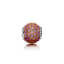

In [10]:
to_image(test_image)

# Define Model

## Define G

In [11]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(args.z_dim, args.G_features * 8,
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(args.G_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(args.G_features * 8, args.G_features * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.G_features * 4, args.G_features * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.G_features * 2, args.G_features,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(args.G_features, args.image_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, x):
        return self.main(x)

## Define D

In [12]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(args.image_channels, args.D_features,
                      4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(args.D_features, args.D_features * 2,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(args.D_features * 2, args.D_features * 4,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(args.D_features * 4, args.D_features * 8,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(args.D_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

## Save losses

In [13]:
class Results():
    def __init__(self, results_path):
        self.D_losses = []
        self.G_losses = []
        self.D_reals = []
        self.D_fakes = []
        self.G_reals = []
        self.results_path = results_path
    
    def save_losses(self, D_loss, G_loss, D_real, D_fake, G_real):
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.D_reals.append(D_real)
        self.D_fakes.append(D_fake)
        self.G_reals.append(G_real)
        
    def save_to_disk(self):
        f = open(self.results_path + "D_losses.pkl", "wb")
        pickle.dump(self.D_losses, f)
        f= open(self.results_path + "G_losses.pkl", "wb")
        pickle.dump(self.G_losses, f)
        f = open(self.results_path + "D_reals.pkl", "wb")
        pickle.dump(self.D_reals, f)
        f = open(self.results_path + "D_fakes.pkl", "wb")
        pickle.dump(self.D_fakes, f)
        f = open(self.results_path + "G_reals.pkl", "wb")
        pickle.dump(self.G_reals, f)
        

## Define Train and Generate

In [14]:
def train(args, data_loader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses):
    D_losses = AverageValueMeter()
    G_losses = AverageValueMeter()
    D_reals = AverageValueMeter()
    D_fakes = AverageValueMeter()
    G_reals = AverageValueMeter()
    
    start = time.time()
    # call Variable after .cuda()
    for i, (real, _) in enumerate(data_loader):
        batch_size = real.size(0)
        real_label = torch.from_numpy(np.full(batch_size, 0.9, np.float32)) #modify here
        fake_label = torch.zeros(batch_size)
        z = torch.randn(batch_size, args.z_dim, 1, 1)
        
        if args.cuda:
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            real = real.cuda()
            z = z.cuda()
        real_label = Variable(real_label)
        fake_label = Variable(fake_label)
        real = Variable(real)
        z = Variable(z)
        
        if D_losses.value()[0] < 0.7*G_losses.value()[0]:
            # Stop training D
            #----------TRAIN D---------------
            # train with real
            real_output = netD(real)
            D_real_loss = criterion(real_output, real_label)
            D_real = real_output.data.mean()
        
            # train with fake
            fake = netG(z)
            fake_output = netD(fake.detach())
            D_fake_loss = criterion(fake_output, fake_label)
            D_fake = fake_output.data.mean()
        
            # loss D
            D_loss = D_real_loss + D_fake_loss
            #netD.zero_grad()
            #D_loss.backward()
            #D_optimizer.step()
            
            #----------TRAIN G---------------
            output = netD(fake)
            G_loss = criterion(output, real_label)
            G_real = output.data.mean()
            netG.zero_grad()
            G_loss.backward()
            G_optimizer.step()    
        else:
            #----------TRAIN D---------------
            # train with real
            real_output = netD(real)
            D_real_loss = criterion(real_output, real_label)
            D_real = real_output.data.mean()
        
            # train with fake
            fake = netG(z)
            fake_output = netD(fake.detach())
            D_fake_loss = criterion(fake_output, fake_label)
            D_fake = fake_output.data.mean()
        
            # loss D
            D_loss = D_real_loss + D_fake_loss
            netD.zero_grad()
            D_loss.backward()
            D_optimizer.step()
            
            #----------TRAIN G---------------
            output = netD(fake)
            G_loss = criterion(output, real_label)
            G_real = output.data.mean()
            netG.zero_grad()
            G_loss.backward()
            G_optimizer.step()
        
        
        # update loss
        D_losses.add(D_loss.data.cpu()[0] * batch_size, batch_size)
        G_losses.add(G_loss.data.cpu()[0] * batch_size, batch_size)
        D_reals.add(D_real * batch_size, batch_size)
        D_fakes.add(D_fake * batch_size, batch_size)
        G_reals.add(G_real * batch_size, batch_size)
        
    print("=> EPOCH {} | Time: {}s | D_loss: {:.4f} | G_loss: {:.4f}"
          " | D_real: {:.4f} | D_fake: {:.4f} | G_real: {:.4f}"
          .format(epoch, round(time.time()-start), D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0]))
    result_losses.save_losses(D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0])

In [15]:
def generate(args, netG, epoch):
    z = torch.randn(args.batch_size, args.z_dim, 1, 1)
    if args.cuda:
        z = z.cuda()
    fake = netG(Variable(z, volatile=True))
    save_image(fake.data.cpu(), os.path.join(args.image_results,
        "fake_sample_epoch_{:02d}.png".format(epoch)), normalize=True)

## Create Model, Define Loss and Optimizer

In [16]:
netG = _netG()
netD = _netD()
criterion = nn.BCELoss()
if args.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()

In [17]:
D_optimizer = optim.Adam(netD.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)
G_optimizer = optim.Adam(netG.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)

## Run Train

In [19]:
result_losses = Results(args.loss_results)
for epoch in range(0, args.epochs):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses)
    generate(args, netG, epoch)

=> EPOCH 0 | Time: 98s | D_loss: 2.5114 | G_loss: 2.9463 | D_real: 0.7546 | D_fake: 0.5746 | G_real: 0.3566
=> EPOCH 1 | Time: 2s | D_loss: 2.0054 | G_loss: 3.7166 | D_real: 0.9187 | D_fake: 0.4542 | G_real: 0.3369
=> EPOCH 2 | Time: 2s | D_loss: 2.1921 | G_loss: 5.4620 | D_real: 0.9010 | D_fake: 0.4786 | G_real: 0.2932
=> EPOCH 3 | Time: 2s | D_loss: 2.3462 | G_loss: 5.4314 | D_real: 0.8400 | D_fake: 0.5139 | G_real: 0.3301
=> EPOCH 4 | Time: 2s | D_loss: 2.4983 | G_loss: 5.4662 | D_real: 0.7454 | D_fake: 0.5781 | G_real: 0.4334
=> EPOCH 5 | Time: 2s | D_loss: 2.0867 | G_loss: 5.3134 | D_real: 0.8581 | D_fake: 0.4248 | G_real: 0.3290
=> EPOCH 6 | Time: 2s | D_loss: 2.4666 | G_loss: 4.9286 | D_real: 0.6064 | D_fake: 0.5501 | G_real: 0.4645
=> EPOCH 7 | Time: 2s | D_loss: 2.3172 | G_loss: 4.9441 | D_real: 0.7529 | D_fake: 0.5574 | G_real: 0.4700
=> EPOCH 8 | Time: 2s | D_loss: 2.2504 | G_loss: 5.0146 | D_real: 0.7647 | D_fake: 0.5469 | G_real: 0.4660
=> EPOCH 9 | Time: 2s | D_loss: 2.25

=> EPOCH 76 | Time: 2s | D_loss: 1.0952 | G_loss: 1.6216 | D_real: 0.5354 | D_fake: 0.2938 | G_real: 0.1930
=> EPOCH 77 | Time: 2s | D_loss: 1.4098 | G_loss: 1.7156 | D_real: 0.4277 | D_fake: 0.3163 | G_real: 0.2022
=> EPOCH 78 | Time: 2s | D_loss: 1.4900 | G_loss: 1.8183 | D_real: 0.4331 | D_fake: 0.2825 | G_real: 0.2038
=> EPOCH 79 | Time: 2s | D_loss: 1.1350 | G_loss: 1.6795 | D_real: 0.5584 | D_fake: 0.3203 | G_real: 0.2175
=> EPOCH 80 | Time: 2s | D_loss: 1.1866 | G_loss: 1.7084 | D_real: 0.5391 | D_fake: 0.3082 | G_real: 0.2078
=> EPOCH 81 | Time: 2s | D_loss: 1.2906 | G_loss: 1.6184 | D_real: 0.5990 | D_fake: 0.3645 | G_real: 0.2703
=> EPOCH 82 | Time: 2s | D_loss: 1.4705 | G_loss: 2.0614 | D_real: 0.4813 | D_fake: 0.2917 | G_real: 0.1695
=> EPOCH 83 | Time: 2s | D_loss: 1.4637 | G_loss: 1.8979 | D_real: 0.5103 | D_fake: 0.3129 | G_real: 0.2285
=> EPOCH 84 | Time: 2s | D_loss: 1.2080 | G_loss: 1.8042 | D_real: 0.5934 | D_fake: 0.3434 | G_real: 0.2094
=> EPOCH 85 | Time: 2s | D_l

=> EPOCH 152 | Time: 2s | D_loss: 1.3293 | G_loss: 1.6601 | D_real: 0.4443 | D_fake: 0.3047 | G_real: 0.2006
=> EPOCH 153 | Time: 2s | D_loss: 1.1850 | G_loss: 1.6458 | D_real: 0.5868 | D_fake: 0.3398 | G_real: 0.2415
=> EPOCH 154 | Time: 2s | D_loss: 1.1793 | G_loss: 1.6983 | D_real: 0.5372 | D_fake: 0.3196 | G_real: 0.2112
=> EPOCH 155 | Time: 2s | D_loss: 1.1579 | G_loss: 1.6794 | D_real: 0.5126 | D_fake: 0.3026 | G_real: 0.1878
=> EPOCH 156 | Time: 2s | D_loss: 1.1495 | G_loss: 1.7320 | D_real: 0.5680 | D_fake: 0.3256 | G_real: 0.2077
=> EPOCH 157 | Time: 2s | D_loss: 1.1399 | G_loss: 1.6023 | D_real: 0.5823 | D_fake: 0.3523 | G_real: 0.2382
=> EPOCH 158 | Time: 2s | D_loss: 1.1263 | G_loss: 1.4988 | D_real: 0.5836 | D_fake: 0.3138 | G_real: 0.2459
=> EPOCH 159 | Time: 2s | D_loss: 1.1912 | G_loss: 1.7295 | D_real: 0.5004 | D_fake: 0.3061 | G_real: 0.1999
=> EPOCH 160 | Time: 2s | D_loss: 1.2700 | G_loss: 1.8823 | D_real: 0.4900 | D_fake: 0.3143 | G_real: 0.1961
=> EPOCH 161 | Time

## Save loss

In [20]:
result_losses.save_to_disk()

## Get one REAL Image

In [21]:
sample, _ = iter(dataloader).next()
save_image(sample, os.path.join(args.results, "real_sample.png"))